In [1]:
#@title Install arviz
# !pip3 install arviz

In [2]:
import arviz as az
import pystan
import os
# os.environ['STAN_NUM_THREADS'] = "4"
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline

## Select model


        About: 

        SICRDq model 

        Some unknown I and known C, both go to recovered and death 

        I and C have same leak to r and d but different to total infected Z
        
S: susceptible
I: infected
C: identified cases
R: recovered
D: dead


/usr/local/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/usr/local/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


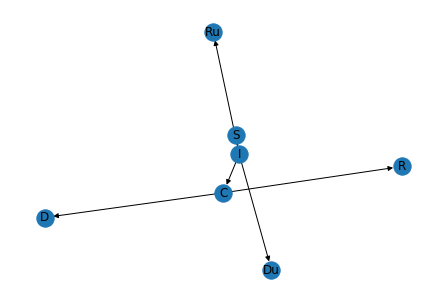

In [3]:
import MBS_epidemic_concentration_models as models
model = models.model_sicrq()
model.plotnetwork()

## Compile

In [4]:
stanrunmodel = pystan.StanModel(model_code=model.stan)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_af361cf5a57a13f67f8ebb8d9717b9ae NOW.


# Load data from JHU



In [5]:
url_confirmed = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
url_deaths = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv"
url_recovered = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv"

dfc = pd.read_csv(url_confirmed)
dfd = pd.read_csv(url_deaths)
dfr = pd.read_csv(url_recovered)

# print(dfc)


## Make JHU ROI DF

### Enter country 

In [6]:
#Austria,Belgium,Denmark,France,Germany,Italy,Norway,Spain,Sweden,Switzerland,United Kingdom
roi = "Italy"

t0 assumed to be: day 29
2/20/20
3/9/20
47


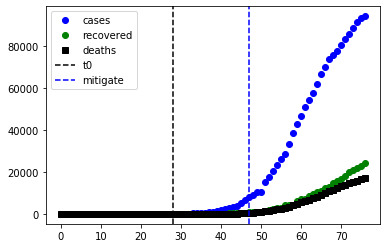

In [7]:
dfc2 = dfc.loc[(dfc['Country/Region']==roi)&(pd.isnull(dfc['Province/State']))]
dfd2 = dfd.loc[(dfd['Country/Region']==roi)&(pd.isnull(dfd['Province/State']))]
dfr2 = dfr.loc[(dfr['Country/Region']==roi)&(pd.isnull(dfr['Province/State']))]


DF = df = pd.DataFrame(columns=['date','cases','recovered','deaths'])

dates_all = dfc.columns[4:].values[:-1]

dates = dates_all[:]

for i in range(len(dates)):
  DF.loc[i] = pd.Series({'date':dates[i],
                         'cases':dfc2[dates[i]].values[0] - (dfr2[dates[i]].values[0] + dfd2[dates[i]].values[0]),
                         'recovered':dfr2[dates[i]].values[0],
                         'deaths':dfd2[dates[i]].values[0]})


pop = {}
pop['Italy'] = 60500000
pop['United Kingdom'] = 64400000
pop['France'] = 66990000

mitigate = {}
mitigate['Italy'] = '3/9/20' #approximate date

t0 = np.where(DF["cases"].values>5)[0][0] - 1# estimated day of first exposure? Need to make this a parameter
model.stan_data['t0'] = t0-1
print("t0 assumed to be: day "+str(t0))
plt.plot(DF["cases"],'bo', label="cases")
plt.plot(DF["recovered"],'go',label="recovered")
plt.plot(DF["deaths"],'ks',label="deaths")

plt.axvline(model.stan_data['t0'],color='k', linestyle="dashed", label='t0')

ind = np.where(mitigate[roi]==dates)[0][0]
plt.axvline(ind,color='b', linestyle="dashed", label='mitigate')
print(dates[t0])
print(dates[ind])
print(ind)

model.stan_data['tm'] = ind

plt.legend()


## Format JHU ROI data for Stan

In [8]:
#truncate time series from t0 on (initial is t0-1)
model.stan_data['ts'] = np.arange(t0,len(dates))  
model.stan_data['y'] = (DF[['cases','recovered','deaths']].to_numpy()).astype(int)[t0:,:]
model.stan_data['n_obs'] = len(dates) - t0

model.stan_data['ts_predict'] = np.arange(t0,len(dates)+365)
model.stan_data['n_obs_predict'] = len(dates) - t0 + 365

### Enter population manually

In [9]:
model.stan_data['n_pop'] = pop[roi] 
model.stan_data['n_scale'] = 10000000


### Print data for Stan 

In [10]:
print(model.stan_data)

{'n_theta': 6, 'n_difeq': 5, 'n_ostates': 3, 't0': 28, 'tm': 47, 'ts': array([29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45,
       46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62,
       63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76]), 'y': array([[    3,     0,     0],
       [   19,     0,     1],
       [   59,     1,     2],
       [  150,     2,     3],
       [  221,     1,     7],
       [  311,     1,    10],
       [  438,     3,    12],
       [  593,    45,    17],
       [  821,    46,    21],
       [ 1053,    46,    29],
       [ 1577,    83,    34],
       [ 1835,   149,    52],
       [ 2263,   160,    79],
       [ 2706,   276,   107],
       [ 3296,   414,   148],
       [ 3916,   523,   197],
       [ 5061,   589,   233],
       [ 6387,   622,   366],
       [ 7985,   724,   463],
       [ 8794,   724,   631],
       [10590,  1045,   827],
       [10590,  1045,   827],
       [14955,  1439,  1266],
       [17750,  196

# Load England School 1978 Influenza data 

In [11]:
# #England 1978 influenza
# cases = [0,8,26,76,225,298,258,233,189,128,150,85,14,4]
# recovered = [0,0,0,0,9,17,105,162,176,166,150,85,47,20]
# plt.plot(cases,'bo', label="cases")
# plt.plot(recovered,'go',label="recovered")
# pop = 763
# model.stan_data['t0'] = 0
# #truncate time series from t0 on (initial is t0-1)
# model.stan_data['n_pop'] = pop 
# model.stan_data['ts'] = np.arange(1,len(cases)+1)  
# Y = np.hstack([np.c_[cases],np.c_[recovered],np.zeros((len(cases),1))]).astype(int)
# model.stan_data['y'] = Y
# model.stan_data['n_obs'] = len(cases)

# plt.plot(cases,'bo', label="cases")
# plt.plot(recovered,'go',label="recovered")

# plt.legend()

# Run Stan 

## Initialize parameters

In [12]:
# Feed in some feasible initial values to start from

# init_par = [{'theta':[0.25,0.01,0.01,0.05,.02],'S0':0.5}] 


if model.name in ["sir1","sir2"]:
    def init_fun():
        x = {'theta':
             [0.5*np.random.uniform()]+
             [0.1*np.random.uniform()]
            }
        return x

if model.name in ["sicu"]:
    def init_fun():
        x = {'theta':
             [0.1*np.random.uniform()]+
             [0.1*np.random.uniform()]+
             [0.5*np.random.uniform()]+
             [0.1*np.random.uniform()]
            }
        return x
    
if model.name in ["sicuq","sicuf"]:
    def init_fun():
        x = {'theta':
             [0.1*np.random.uniform()]+
             [0.1*np.random.uniform()]+
             [0.5*np.random.uniform()]+
             [0.1*np.random.uniform()]+
             [0.1*np.random.uniform()]
            }
        return x
    
if model.name in ["sicrqm"]:
    def init_fun():
        x = {'theta':
             [0.1*np.random.uniform()]+
             [0.1*np.random.uniform()]+
             [0.1*np.random.uniform()]+
             [0.1*np.random.uniform()]+
             [0.5*np.random.uniform()]+
             [0.5*np.random.uniform()]+
             [7*np.random.uniform()]+
             [0.1*np.random.uniform()]}
        return x

    

if model.name in ["sicrq"]:
    def init_fun():
        x = {'theta':
             [np.random.lognormal(np.log(0.1),1)]+
             [np.random.lognormal(np.log(0.1),1)]+
             [np.random.lognormal(np.log(0.1),1)]+
             [np.random.lognormal(np.log(0.1),1)]+
             [np.random.lognormal(np.log(0.25),1)]+
             [np.random.lognormal(np.log(0.1),1)]}
        return x

## Fit Stan 

In [22]:
n_chains=8
n_warmups=1000
n_iter=10000
n_thin=50

control = {'adapt_delta':0.95}
fit = stanrunmodel.sampling(data = model.stan_data,init = init_fun,control=control, chains = n_chains, warmup = n_warmups, iter = n_iter, thin=n_thin, seed=13219)



To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [23]:
print(fit)

Inference for Stan model: anon_model_af361cf5a57a13f67f8ebb8d9717b9ae.
8 chains, each with iter=10000; warmup=1000; thin=50; 
post-warmup draws per chain=180, total post-warmup draws=1440.

                   mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
theta[1]         9.0e-4  5.8e-8 2.3e-6 9.0e-4 9.0e-4 9.0e-4 9.0e-4 9.1e-4   1559    1.0
theta[2]           0.02  9.8e-7 3.7e-5   0.02   0.02   0.02   0.02   0.02   1407    1.0
theta[3]           0.01  8.4e-7 3.1e-5   0.01   0.01   0.01   0.01   0.01   1372    1.0
theta[4]           0.13  4.5e-3   0.15   0.01   0.05   0.09   0.17   0.55   1070    1.0
theta[5]           0.25  1.7e-5 5.9e-4   0.24   0.25   0.25   0.25   0.25   1234    1.0
theta[6]          4.0e4    9.32 346.34  3.9e4  3.9e4  4.0e4  4.0e4  4.0e4   1382    1.0
u[1,1]           4.3e-6  1.0e-9 3.8e-8 4.2e-6 4.3e-6 4.3e-6 4.3e-6 4.4e-6   1356    1.0
u[2,1]           9.1e-6  2.2e-9 8.0e-8 9.0e-6 9.1e-6 9.1e-6 9.2e-6 9.3e-6   1358    1.0
u[3,1]           1

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1368faa10>,
      dtype=object)

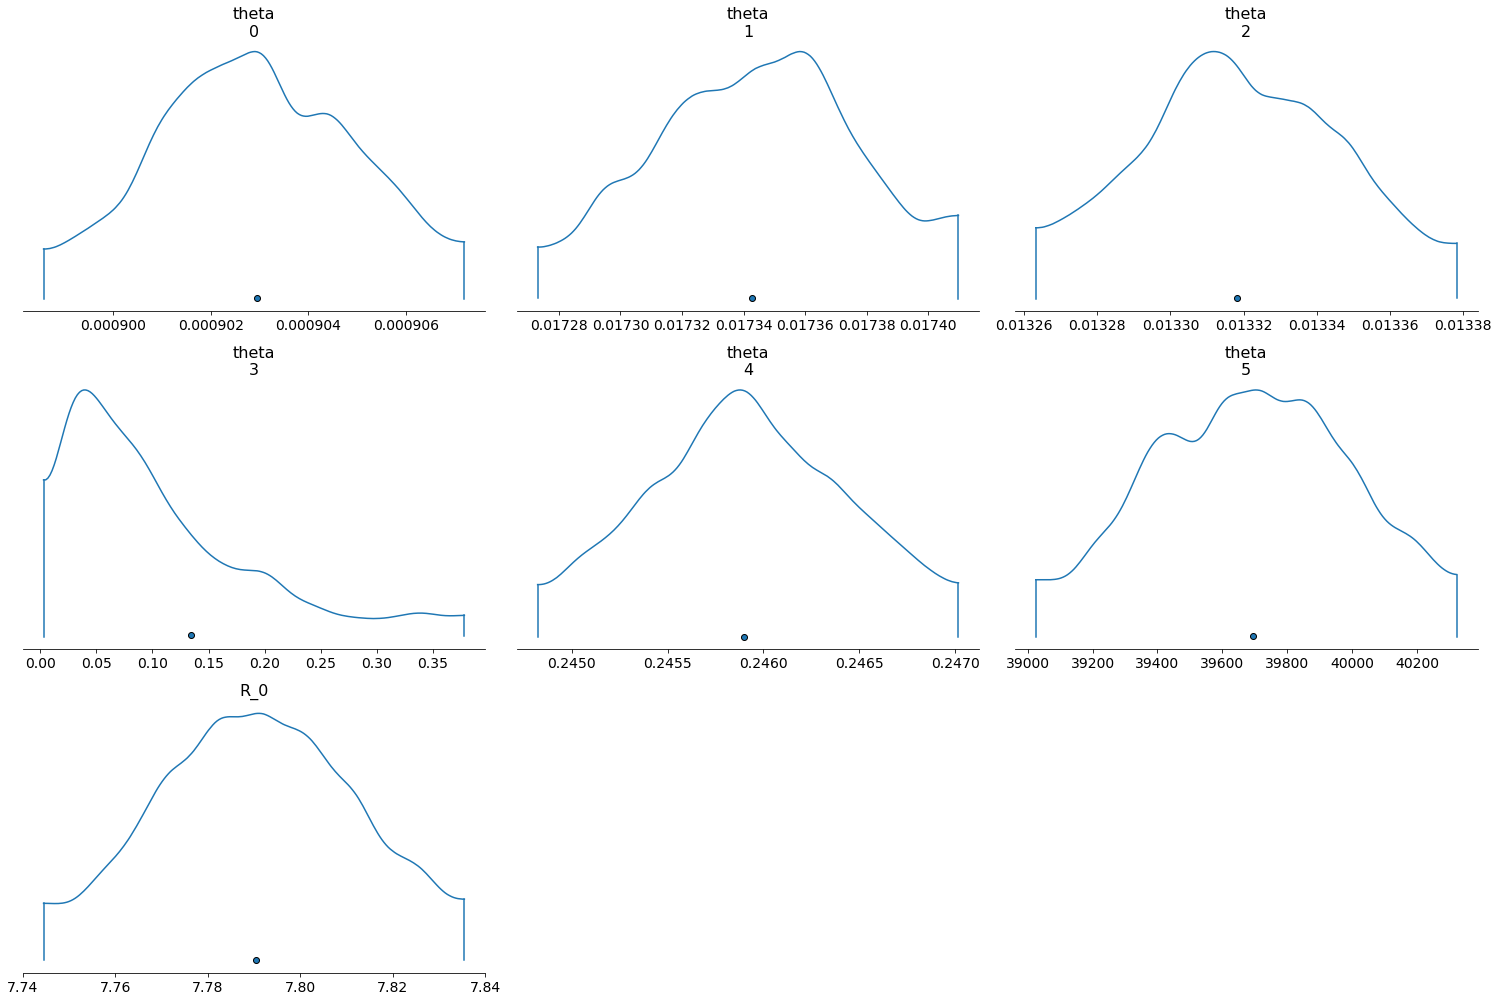

In [24]:
#https://arviz-devs.github.io/arviz/generated/arviz.plot_density
az.plot_density(fit,group='posterior',var_names=["theta","R_0"])

48
(77, 4)


array([<matplotlib.axes._subplots.AxesSubplot object at 0x13a8f77d0>,
      dtype=object)

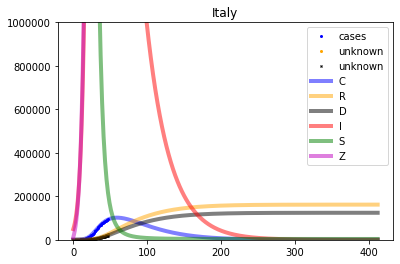

<Figure size 432x288 with 0 Axes>

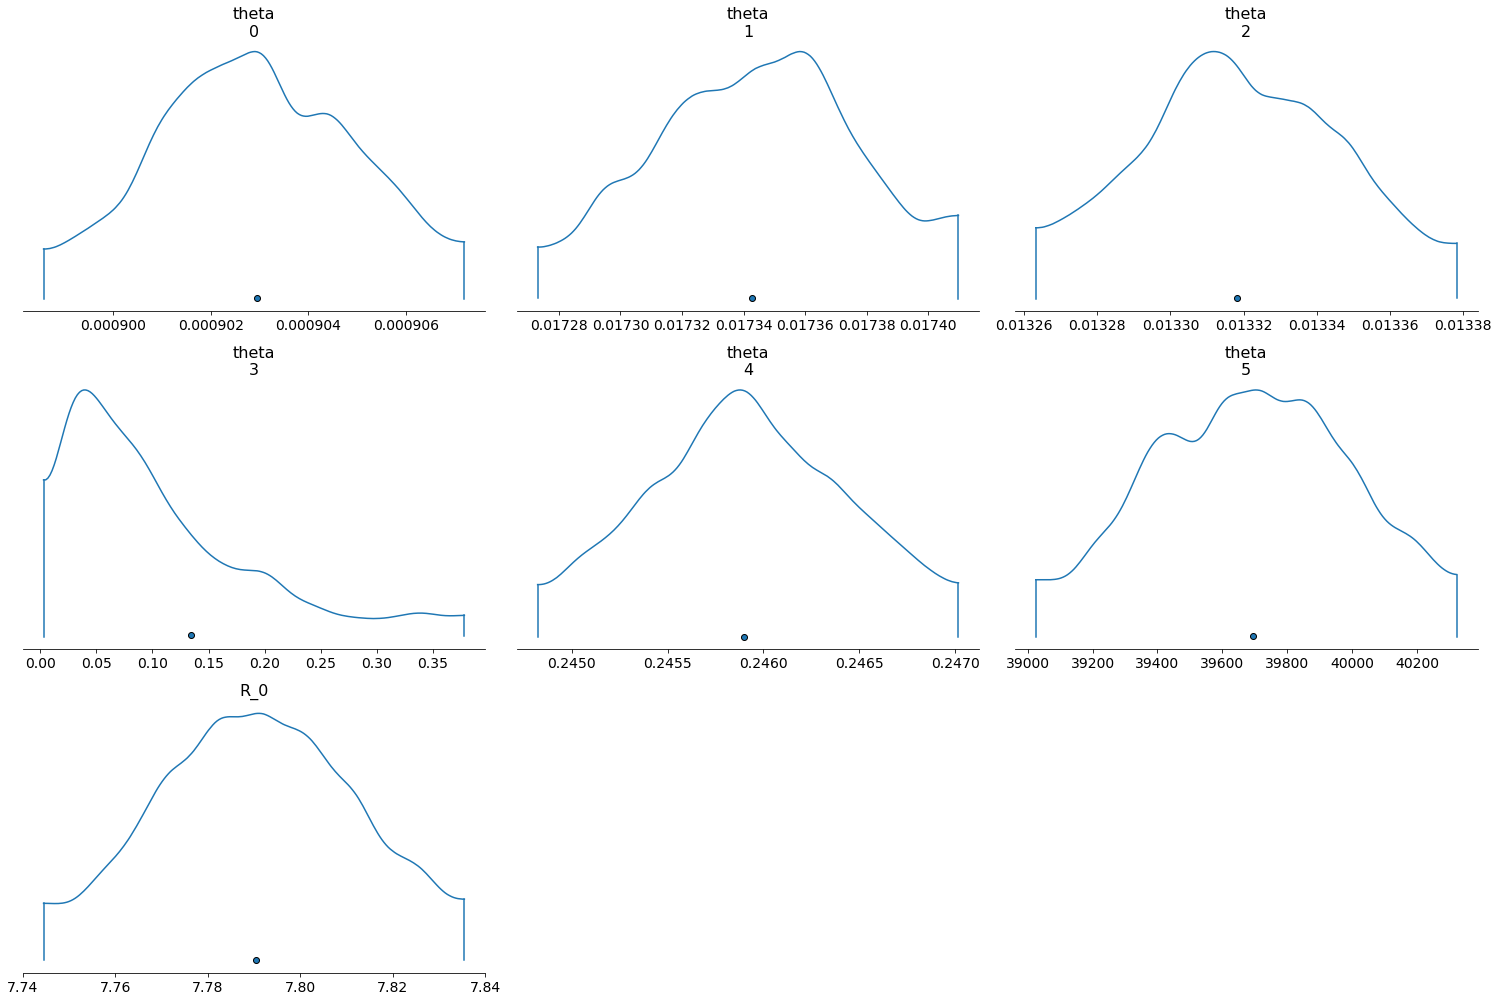

In [25]:
ms=2 
# x = range(len(fit.extract()['u'][-1,:,0]))

DF = df = pd.DataFrame(columns=['date','cases','recovered','deaths'])

dates_all = dfc.columns[4:].values[:-1]

dates = dates_all

for i in range(len(dates)):
  DF.loc[i] = pd.Series({'date':dates[i],
                         'cases':dfc2[dates[i]].values[0] - (dfr2[dates[i]].values[0] + dfd2[dates[i]].values[0]),
                         'recovered':dfr2[dates[i]].values[0],
                         'deaths':dfd2[dates[i]].values[0]})

x = range(len(dates[t0:]))

print(len(x))
print(np.shape(DF))

if model.name in ["sir1","sir2"]:
    plt.plot(x,DF["cases"][t0:],'bo', label="cases",ms=ms)
    plt.plot(x,DF["recovered"][t0:] + DF["deaths"][t0:],'o',color='orange',label="unknown",ms=ms)
    labels = ["S","I","U","Z"]
    c_ = ["g","b","orange","r"]
    Sind = 0
    n = 3

if model.name in ["sicu","sicuf","sicuq"]:
    plt.plot(x,DF["cases"][t0:],'bo', label="cases",ms=ms)
    plt.plot(x,DF["recovered"][t0:] + DF["deaths"][t0:],'o',color='orange',label="unknown",ms=ms)
    labels = ['C','U','I','S','Z']
    c_ = ['b','orange','r','g','m']
    n = 4

if model.name in ["sicrq","sicrqm"]:
    plt.plot(x,DF["cases"][t0:],'bo', label="cases",ms=ms)
    plt.plot(x,DF["recovered"][t0:],'o',color='orange',label="unknown",ms=ms)
    plt.plot(x,DF["deaths"][t0:],'x',color='k',label="unknown",ms=ms)
    labels = ['C','R','D','I','S','Z']
    c_ = ['b','orange','k','r','g','m']
    Sind = 4
    n = 5   
    
lw=4
a = 0.5
for i in range(n):
    plt.plot(model.stan_data['n_scale']*fit.extract()['u_predict'][-1,:,i],label=labels[i],lw=lw,alpha=a,color=c_[i])
plt.plot(model.stan_data['n_scale']*(1-fit.extract()['u_predict'][-1,:,Sind]),label=labels[-1],lw=lw,alpha=a,color=c_[-1])
plt.legend()
plt.ylim((0,1000000))

# lbC = []
# ubC = []
# lbR = []
# ubR = []
# lbD = []
# ubD = []
# for i in range(1,47):
#     print(i)
#     x = fit.stansummary(pars=[f'u[{i},1]'], probs=(0.25,0.975), digits_summary=2).split('\n')[5]
# #     print(x.split('\t'))
#     lbC.append(model.stan_data['n_scale']*float(x.split(' ')[5]))
#     ubC.append(model.stan_data['n_scale']*float(x.split(' ')[6]))
#     x = fit.stansummary(pars=[f'u[{i},2]'], probs=(0.25,0.975), digits_summary=2).split('\n')[5]
# #     print(x.split(' '))
#     lbR.append(model.stan_data['n_scale']*float(x.split(' ')[3]))
#     ubR.append(model.stan_data['n_scale']*float(x.split(' ')[4]))
#     x = fit.stansummary(pars=[f'u[{i},4]'], probs=(0.25,0.975), digits_summary=2).split('\n')[5]
# #     print(x.split(' '))
# #     lbD.append(model.stan_data['n_scale']*float(x.split(' ')[5]))
# #     ubD.append(model.stan_data['n_scale']*float(x.split(' ')[6]))

# plt.plot(lbC)
# plt.plot(ubC)
# plt.plot(lbR)
# plt.plot(ubR)

# labels = ['C','D','R','I','S','Z']
# lw=4
# a = 0.5
# for i in range(5):
#     plt.plot(model.stan_data['n_scale']*fit.extract()['u'][-1,:,i],label=labels[i],lw=lw,alpha=a)
# plt.plot(model.stan_data['n_scale']*(1-fit.extract()['u'][-1,:,4]),label=labels[-1],lw=lw,alpha=a)
# plt.legend()
# plt.ylim((0,100000))

# plt.subplot(1,2,2)
# tot = DF["cases"][-1:] + DF["recovered"][-1:] + DF["deaths"][-1:]

# plt.axvline(model.stan_data['t0'],color='k', linestyle="dashed")
plt.legend()
plt.title(roi)
plt.figure()
# plt.plot(fit.extract()['lp__'])
az.plot_density(fit,group='posterior',var_names=["theta","R_0"])



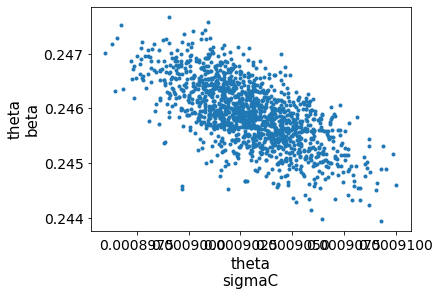

In [26]:
# theta = az.from_pystan(posterior=fit, coords={'a': ['sigmaC','sigmaR', 'sigmaD', 'q','beta','inittheta']}, dims={'theta': ['a']})


# az.plot_pair(theta,var_names=["theta"], coords={'a':['sigmaC','beta']})

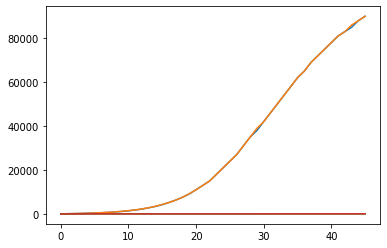

In [28]:
# lbC = []
# ubC = []
# lbR = []
# ubR = []
# lbD = []
# ubD = []
# for i in range(1,47):
# #     print(i)
#     x = fit.stansummary(pars=[f'u_predict[{i},1]'], probs=(0.25,0.975), digits_summary=2).split('\n')[5]
# #     print(x.split('\t'))
#     lbC.append(model.stan_data['n_scale']*float(x.split(' ')[5]))
#     ubC.append(model.stan_data['n_scale']*float(x.split(' ')[6]))
#     x = fit.stansummary(pars=[f'u_predict[{i},2]'], probs=(0.25,0.975), digits_summary=2).split('\n')[5]
# #     print(x.split(' '))
#     lbR.append(model.stan_data['n_scale']*float(x.split(' ')[3]))
#     ubR.append(model.stan_data['n_scale']*float(x.split(' ')[4]))
# #     x = fit.stansummary(pars=[f'u_predict[{i},4]'], probs=(0.25,0.975), digits_summary=2).split('\n')[5]
# #     print(x.split(' '))
# #     lbD.append(model.stan_data['n_scale']*float(x.split(' ')[5]))
# #     ubD.append(model.stan_data['n_scale']*float(x.split(' ')[6]))

# plt.plot(lbC)
# plt.plot(ubC)
# plt.plot(lbR)
# plt.plot(ubR)
# plt.plot(lbD)
# plt.plot(ubD)

# fit.stansummary(pars=['u[1,1]'], probs=(0.25,0.975), digits_summary=2)

In [29]:
# u = az.from_pystan(posterior=fit, coords={'a': ['11']}, dims={'u': ['a']})


# axes = az.plot_forest(
#     u,
#     kind="forestplot",
#     var_names= ['u'],
#     coords = {'a':['0']},
#     combined=True,
#     ridgeplot_overlap=1.5,
#     colors="blue",
#     figsize=(9, 4),
# )

ValueError: conflicting sizes for dimension 'a': length 48 on the data but length 1 on coordinate 'a'

In [ ]:
# print(np.shape(fit.extract()['u']))

In [ ]:
#  as.data.frame(summary(fit)[['u']])